In [1]:
from argparse import ArgumentParser, FileType
from dataclasses import dataclass
from distutils.util import strtobool
import csv
from csv import DictReader
import numpy as np
import pandas as pd
import os
from typing import Optional

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
scored_predictions = pd.read_csv("../data/2021_annual.csv")

def parse_credence(c): return round(float(c[:-1]) / 100, 2) if len(c) > 0 else np.nan

scored_predictions["Credence"] = scored_predictions["Credence"].map(parse_credence)
resolved_scored_predictions = scored_predictions[~scored_predictions["Resolution"].isna()]
resolved_scored_predictions

,Prediction,Credence,Category,Resolution,Source
0,Another baby born from an embryo publicly decl...,0.03,Science,False,NaN
1,Proof that $ \rm{P} = \rm{NP} $ (confirmed by ...,0.00,Science,False,NaN
2,Proof that $ \rm{P} \neq \rm{NP} $ (confirmed ...,0.01,Science,False,NaN
3,Language model released that uses 10x the # of...,0.40,Science,False,NaN
4,Highest exact match rate on SQuAD 2.0 $ >92.0 ...,0.60,Science,False,NaN
6,Waymo self-driving car service open to the pub...,0.20,Tech,False,NaN
7,Another company's self-driving car service ope...,0.10,Tech,False,NaN
8,SpaceX starship has a successful test launch i...,0.60,Tech,True,NaN
9,First Tesla Cybertruck delivered to customer i...,0.45,Tech,False,NaN
10,Top price performance (in G3D Mark / \\$) of G...,0.55,Tech,False,NaN


In [3]:
def get_log_score(credences, resolutions): 
    """
    Computes the entropy except with the observed outcomes for the sum. 
    
    Lower numbers are better.
    """
    return np.mean(- (1-resolutions) * np.log(1-credences) - resolutions * np.log(credences))

def get_brier_score(credences, resolutions):
    residuals = (credences - resolutions)
    return np.mean(residuals ** 2) 

In [4]:
resolutions = resolved_scored_predictions["Resolution"].astype('int').values
credences = resolved_scored_predictions["Credence"].values

In [5]:
get_brier_score(credences, resolutions)

0.17867999999999998

In [6]:
get_log_score(credences, resolutions)

/Users/stephenmalina/anaconda3/envs/dyno_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/stephenmalina/anaconda3/envs/dyno_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


nan

In [7]:
categories = resolved_scored_predictions.Category.unique()
category_brier_scores = []
category_log_scores = []
for category in categories:
    resolved_scored_predictions_category = resolved_scored_predictions.query(f"Category == '{category}'")
    assert len(resolved_scored_predictions_category) > 0, category
    category_resolutions = resolved_scored_predictions_category["Resolution"].astype('int').values
    category_credences = resolved_scored_predictions_category["Credence"].values
    category_brier_scores.append(get_brier_score(category_credences, category_resolutions))
    category_log_scores.append(get_log_score(category_credences, category_resolutions))
category_counts = resolved_scored_predictions.Category.value_counts().sort_index()

/Users/stephenmalina/anaconda3/envs/dyno_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/stephenmalina/anaconda3/envs/dyno_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


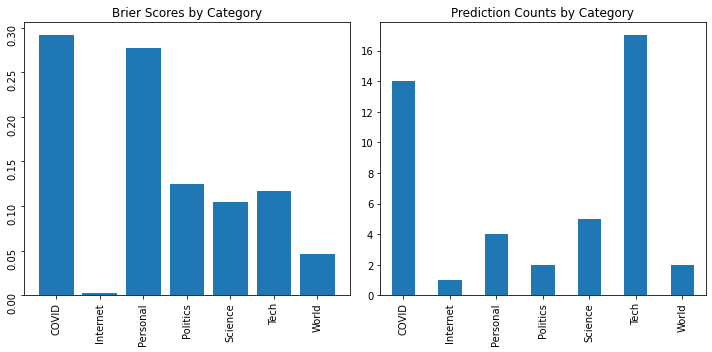

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(x=sorted(categories), height=np.array(category_brier_scores)[np.argsort(categories)])
axs[0].tick_params(labelrotation=90)
axs[0].set_title("Brier Scores by Category")
category_counts.plot.bar(ax=axs[1])
axs[1].set_title("Prediction Counts by Category")
fig.tight_layout()
fig.savefig("../figures/2021_category_brier_scores.png", bbox_inches="tight")

In [9]:
category_brier_scores

[0.1042,
 0.11693529411764707,
 0.125,
 0.04625000000000001,
 0.2911928571428572,
 0.0025000000000000044,
 0.27749999999999997]

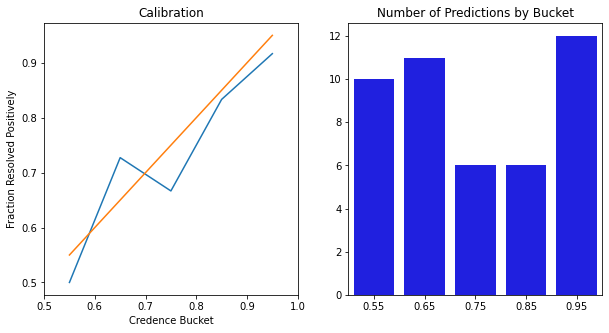

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
bin_size = 0.1
bins = np.array([round(b, 1) for b in np.arange(.5, 1.01, bin_size)])
fractions, counts = [], []
for i, b in enumerate(bins[:-1]):
    nb = bins[i+1]
    yes_df = resolved_scored_predictions[
        ((resolved_scored_predictions['Credence'] >= b) &
        (resolved_scored_predictions['Credence'] < nb))
    ]
    no_df = resolved_scored_predictions[
        ((resolved_scored_predictions['Credence'] < round(1-b, 1)) &
        (resolved_scored_predictions['Credence'] >= round(1-nb, 1)))
    ]
    numer = yes_df['Resolution'].sum() + (1-no_df['Resolution']).sum()
    denom = len(yes_df) + len(no_df)
    fractions.append(numer / denom)
    counts.append(denom)
    
    
axs[0].plot(bins[:-1] + bin_size / 2, fractions)
axs[0].plot([0.55, 0.95], [0.55, 0.95])
axs[0].set_xlabel("Credence Bucket")
axs[0].set_ylabel("Fraction Resolved Positively")
axs[0].set_xticks(bins)
axs[0].set_title("Calibration")
sns.barplot(x=[round(b + bin_size / 2, 2)  for b in bins[:-1]], y=counts, ax=axs[1], color="blue")
axs[1].set_title("Number of Predictions by Bucket");
plt.savefig("../figures/2021_calibration_plot.png")

In [11]:
eric_scored_predictions = pd.read_csv("../data/2021_eric_neyman_annual.csv")

In [12]:
merged_scored_predictions = eric_scored_predictions.merge(
    scored_predictions, suffixes=("_eric", "_stephen"), left_on="Prediction", right_on="Prediction"
)
merged_scored_predictions["Credence_eric"] = merged_scored_predictions["Credence_eric"].map(parse_credence)
resolved_merged_scored_predictions = merged_scored_predictions[~merged_scored_predictions["Resolution_eric"].isna()]
resolved_merged_scored_predictions

,Prediction,Credence_eric,Category_eric,Resolution_eric,Source_eric,Credence_stephen,Category_stephen,Resolution_stephen,Source_stephen
0,Proof that $ \rm{P} = \rm{NP} $ (confirmed by ...,0.00,Science,False,NaN,0.00,Science,False,NaN
1,Proof that $ \rm{P} \neq \rm{NP} $ (confirmed ...,0.01,Science,False,NaN,0.01,Science,False,NaN
3,Bitcoin price >$10k,0.92,Tech,True,NaN,0.80,Tech,True,NaN
4,Bitcoin price >$75k,0.08,Tech,False,NaN,0.05,Tech,False,NaN
5,Bitcoin price >$100k,0.04,Tech,False,NaN,0.02,Tech,False,NaN
6,ETH price >$200,0.91,Tech,True,NaN,0.95,Tech,True,NaN
7,ETH price >$500,0.68,Tech,True,NaN,0.60,Tech,True,NaN
8,ETH price >$1k,0.40,Tech,True,NaN,0.55,Tech,True,NaN
9,ETH price >$2k,0.16,Tech,True,NaN,0.25,Tech,True,NaN
10,ETH price >$5k,0.05,Tech,False,NaN,0.10,Tech,False,NaN


In [13]:
eric_resolutions = resolved_merged_scored_predictions["Resolution_eric"].astype('int').values
eric_credences = resolved_merged_scored_predictions["Credence_eric"].values
stephen_resolutions = resolved_merged_scored_predictions["Resolution_stephen"].astype('int').values
stephen_credences = resolved_merged_scored_predictions["Credence_stephen"].values

In [14]:
round(get_brier_score(eric_credences, eric_resolutions), 2), round(get_brier_score(stephen_credences, stephen_resolutions), 2)

(0.2, 0.2)